# Historical Stockout Features

This notebook defines the "consecutive days without sales" thresholds to use to filter out stockouts per store-category-department.

1. Distribution of "consecutive days without sales" per store-category-department.
2. KS-statistic comparisson between the observations ketp and the observations filtered. The objective is to achieve the highest significant KS statistic by filtering the lowest perent of observations. 

In [1]:
# Import required libraries
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)

# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months,
        stckt.is_stockout_tgt,
        stckt.is_stockout,
        stckt.stck_indicator_max_days_since_last_sale,
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    LEFT JOIN `porygon-pipelines.walmart_featurestore.item_longevity_features` long
        ON tgt.ctx_item_id = long.ctx_item_id
        AND tgt.ctx_date_month = long.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND long.fea_item_longevity_months >=0
"""

stockout_feas_query = """
    SELECT 
    *
    FROM `porygon-pipelines.walmart_featurestore.historical_stockout_features`
    WHERE 
        ctx_store_id = 'CA_1'
"""


# Extract data
item_sales = bq_client.load_from_query(sales_query)
stockout_feas = bq_client.load_from_query(stockout_feas_query)

item_sales = item_sales[
    (item_sales["ctx_date_month"]>=pd.to_datetime("2011-02-01"))
    & (item_sales["ctx_date_month"]<=pd.to_datetime("2015-11-01"))
     ]

# Merge dataframes on 'ctx_date_month'
df_merged = item_sales.merge(
    stockout_feas,
    on=["ctx_date_month", "ctx_item_id", "ctx_dept_id"]
)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 156772 rows from custom query.
INFO:src.core.clients.bigquery:Loaded 195136 rows from custom query.


In [2]:
# Describe df_merged.
print(f"Shape of df_merved is {df_merged.shape}")
display(df_merged.head())

Shape of df_merved is (140476, 150)


,ctx_date_month,ctx_cat_id,ctx_dept_id,ctx_item_id,tgt_monthly_sales,tgt_monthly_sales_sum_3_next_months,is_stockout_tgt,is_stockout,stck_indicator_max_days_since_last_sale,ctx_store_id,...,fea_dept_days_since_last_saleq75_roll_avg_6_months,fea_dept_days_since_last_saleq75_roll_std_6_months,fea_dept_days_since_last_saleq75_roll_avg_12_months,fea_dept_days_since_last_saleq75_roll_std_12_months,fea_dept_max_days_since_last_sale_roll_avg_3_months,fea_dept_max_days_since_last_sale_roll_std_3_months,fea_dept_max_days_since_last_sale_roll_avg_6_months,fea_dept_max_days_since_last_sale_roll_std_6_months,fea_dept_max_days_since_last_sale_roll_avg_12_months,fea_dept_max_days_since_last_sale_roll_std_12_months
0,2015-08-01,FOODS,FOODS_1,FOODS_1_004,380,540,0,0,0,CA_1,...,2.857143,0.899735,3.153846,0.800641,659.75,39.634791,613.857143,66.119661,524.000000,116.679761
1,2013-01-01,FOODS,FOODS_1,FOODS_1_004,146,1263,0,0,16,CA_1,...,4.142857,1.573592,3.615385,1.325296,201.75,39.634791,175.285714,44.709113,221.153846,89.460276
2,2015-06-01,FOODS,FOODS_1,FOODS_1_004,601,1168,0,0,0,CA_1,...,2.857143,0.899735,3.461538,1.330124,598.50,39.247081,553.285714,65.119670,477.923077,99.696591
3,2014-11-01,FOODS,FOODS_1,FOODS_1_018,292,1001,0,0,0,CA_1,...,6.142857,5.398412,10.384615,7.942905,389.50,34.818577,395.428571,38.573986,386.230769,38.168822
4,2012-09-01,FOODS,FOODS_1,FOODS_1_018,421,1259,0,0,0,CA_1,...,3.142857,0.899735,3.461538,1.126601,128.00,28.705400,190.714286,82.705732,246.769231,92.320234


# Utils plot functions

In [3]:
item_sales_focus = df_merged.copy()

def plot_tgt_vs_feature(feature_name):
    fig, ax1 = plt.subplots(figsize=(12,5))
    sns.lineplot(data=item_sales_focus, x='ctx_date_month', y='tgt_monthly_sales_sum_3_next_months', marker='o', ax=ax1, color='tab:blue', label="tgt_monthly_sales_sum_3_next_months")
    ax1.set_ylabel('tgt_monthly_sales_sum_3_next_months', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    sns.lineplot(data=item_sales_focus, x='ctx_date_month', y=feature_name, marker='o', ax=ax2, color='tab:orange', label=feature_name)
    ax2.set_ylabel(feature_name, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title(f'tgt_monthly_sales_sum_3_next_months and {feature_name} over Time')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()

def plot_tgt_vs_feature_per_dept(feature_name, dept_id):
    fig, ax1 = plt.subplots(figsize=(12,5))
    item_sales_focus = df_merged[df_merged["ctx_dept_id"]==dept_id]
    sns.lineplot(data=item_sales_focus, x='ctx_date_month', y='tgt_monthly_sales_sum_3_next_months', marker='o', ax=ax1, color='tab:blue', label="tgt_monthly_sales_sum_3_next_months")
    ax1.set_ylabel('tgt_monthly_sales_sum_3_next_months', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    sns.lineplot(data=item_sales_focus, x='ctx_date_month', y=feature_name, marker='o', ax=ax2, color='tab:orange', label=feature_name)
    ax2.set_ylabel(feature_name, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title(f'tgt_monthly_sales_sum_3_next_months and {feature_name} over Time')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()
    
def plot_distribution_days_since_last_sales(dept_id, cutoff_point):
    df_merged_filtered = df_merged[df_merged["ctx_dept_id"]==dept_id]
    plt.figure(figsize=(10,6))
    sns.kdeplot(df_merged_filtered['fea_item_max_days_since_last_sale'], fill=True, bw_adjust=0.5)
    plt.title(f'Density of Days Since Last Sale in Dept {dept_id}')
    plt.xlabel('Days Since Last Sale')
    plt.ylabel('Density (Fraction of Total)')
    plt.xscale('log')
    plt.axvline(x=cutoff_point, color='red', linestyle='--', label='Cutoff Point')
    plt.show()
    observations_filtered = df_merged_filtered[df_merged_filtered['fea_item_max_days_since_last_sale']>cutoff_point].shape[0]
    percent_filtered = observations_filtered/df_merged_filtered.shape[0]
    print(f"This cutoff would potentially remove {percent_filtered:.2f} of observations.")

from scipy.stats import ks_2samp

def calculate_cutoff_results(n):
    dept_id_list = ["FOODS_1", "FOODS_2", "FOODS_3", "HOBBIES_1", "HOBBIES_2", "HOUSEHOLD_1", "HOUSEHOLD_2"]
    ks_list = []
    pvalue_list = []
    stockout_percent_list = []
    percent_zero_stockout_group_list = []
    percent_zero_non_stockout_group_list = []

    colname = f"solid_thrshold_{n}"
    df_merged[f"solid_thrshold_{n}"] = n

    for dept_id in dept_id_list:
        dept_data = df_merged[(df_merged["ctx_dept_id"]==dept_id)]
        stockout_group = dept_data[
            (dept_data["stck_indicator_max_days_since_last_sale"]>=dept_data[colname])
            ]["tgt_monthly_sales"]
        non_stockout_group = dept_data[
            (dept_data["stck_indicator_max_days_since_last_sale"]<dept_data[colname])
            ]["tgt_monthly_sales"]
        percent_zero_stockout_group = (stockout_group==0).sum()/stockout_group.shape[0]
        percent_zero_non_stockout_group = (non_stockout_group==0).sum()/non_stockout_group.shape[0]

        percent_excluded = stockout_group.shape[0]/(stockout_group.shape[0]+non_stockout_group.shape[0])

        ks_stat, p_value = ks_2samp(non_stockout_group, stockout_group)
        ks_list.append(ks_stat)
        pvalue_list.append(p_value)
        stockout_percent_list.append(percent_excluded)
        percent_zero_stockout_group_list.append(percent_zero_stockout_group)
        percent_zero_non_stockout_group_list.append(percent_zero_non_stockout_group)

    df_results = pd.DataFrame(dept_id_list, columns = ["ctx_dept_id"])
    df_results["ks_stat"] = ks_list
    df_results["p_value"] = pvalue_list
    df_results["percent_excluded"] = stockout_percent_list
    df_results["percent_zero_stockout_group"] = percent_zero_stockout_group_list
    df_results["percent_zero_non_stockout_group"] = percent_zero_non_stockout_group_list
    df_results["threshold"] = n

    return df_results

def plot_sales_distribution_comparisson(dept_id, cutoff_point):
    df_merged_filtered = df_merged[df_merged["ctx_dept_id"]==dept_id]
    df_merged_filtered["population"] = "Keep"
    df_merged_filtered.loc[
        df_merged_filtered["fea_item_max_days_since_last_sale"]>cutoff_point,
        "population"
    ] = "Filter"
    plt.figure(figsize=(10,6))
    sns.kdeplot(df_merged_filtered, x='tgt_monthly_sales', fill=True, bw_adjust=0.5, hue="population")
    plt.title(f'Density of Monthly Sales - {dept_id}')
    plt.xlabel('Monthly Sales')
    plt.ylabel('Density (Fraction of Total)')
    plt.xscale('log')
    plt.show()
    observations_filtered = df_merged_filtered[df_merged_filtered['fea_item_max_days_since_last_sale']>cutoff_point].shape[0]
    percent_filtered = observations_filtered/df_merged_filtered.shape[0]
    print(f"This cutoff would potentially remove {percent_filtered:.2f} of observations.")


def plot_cutoff_per_dept(df_cutoff_analysis, dept_id, plot_inflection_point):
    df_cutoff_analysis_dept = df_cutoff_analysis[
        df_cutoff_analysis["ctx_dept_id"]==dept_id
    ].reset_index(drop=True)
    # Line plot: x = threshold, y = ks_stat
    plt.figure(figsize=(10,6))
    
    ax = sns.lineplot(
        data=df_cutoff_analysis_dept,
        x="threshold",
        y="ks_stat",
        marker="o",
    )
    plt.title(f"KS Statistic vs Percent Excluded by Threshold Type - {dept_id}")
    plt.xlabel("Threshold")
    plt.ylabel("KS Statistic")
    plt.axvline(x=plot_inflection_point, color='red', linestyle='--', label='Cutoff Point')

    # Annotate each marker with percent_excluded value, smaller font size
    for i, row in df_cutoff_analysis_dept.iterrows():
        if i % 4 == 0:
            ax.annotate(f"{row['percent_excluded']:.2f}",
                        (row['threshold'], row['ks_stat']),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center',
                        fontsize=10,
                        color='black')

    plt.legend()
    plt.tight_layout()
    plt.show()

# from 1 to 90:
list_of_ns = list(range(1, 91))

df_cutoff_analysis = pd.concat(
    [
        calculate_cutoff_results(n) for n in list_of_ns

    ]
)


In [4]:
def plot_stockout_threhodls_per_dept(dept_id, cutoff):
    df_merged_within_thresholds = df_merged[
        (cutoff >= df_merged["stck_indicator_max_days_since_last_sale"]) &
        (df_merged["ctx_dept_id"] == dept_id)
    ]

    df_merged_outside_thresholds = df_merged[
        (cutoff < df_merged["stck_indicator_max_days_since_last_sale"]) &
        (df_merged["ctx_dept_id"] == dept_id)
    ]

    fig, ax1 = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df_merged_within_thresholds, x='ctx_date_month', y='tgt_monthly_sales', marker='o', ax=ax1, color='tab:blue', label="target when within threshold")
    ax1.set_ylabel('within threshold', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    sns.lineplot(data=df_merged_outside_thresholds, x='ctx_date_month', y="tgt_monthly_sales", marker='o', ax=ax1, color='tab:orange', label="target when outside threshold")
    ax1.set_title(f'Monthly Sales within and outside threshold over Time - {dept_id}')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()

def plot_count_stockout_threhodls_per_dept(dept_id, cutoff):
    df_merged_within_thresholds = df_merged[
        (cutoff >= df_merged["stck_indicator_max_days_since_last_sale"]) &
        (df_merged["ctx_dept_id"] == dept_id)
    ].groupby(
        "ctx_date_month"
    ).count().reset_index()

    df_merged_outside_thresholds = df_merged[
        (cutoff < df_merged["stck_indicator_max_days_since_last_sale"]) &
        (df_merged["ctx_dept_id"] == dept_id)
    ].groupby(
        "ctx_date_month"
    ).count().reset_index()

    fig, ax1 = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df_merged_within_thresholds, x='ctx_date_month', y='tgt_monthly_sales', marker='o', ax=ax1, color='tab:blue', label="Count Observations Within Threshold")
    ax1.set_ylabel('within threshold', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    sns.lineplot(data=df_merged_outside_thresholds, x='ctx_date_month', y="tgt_monthly_sales", marker='o', ax=ax1, color='tab:orange', label="Count Observations Outside Threshold")
    ax1.set_title(f'Count Observations within and outside threshold over Time - {dept_id}')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()



# Manually Iterate per Department

## 1. KS Stat Plot Description (first plot)
1. Y axis: The KS Statistic. The higher the statistic, thte mor different the target populations at each treshold. 
2. X axis: Respective cutoff threshold (max days since last sale) to separate both pouplations. 
3. Observation values (annotations): The percent of the total popluation that would be filtered out at each cutoff treshold.

## 2. Days Since Last Sale - Density Plot (second plot)
1. Y axis: The proportion of total observations at each X value. 
2. X axis: Log Scale Days Since Last Sale.

## 3. Target Distribution Comparisson - Density Plot (third plot)
1. Y axis: The proportion of total observations with each X value. 
2. X axis: Log Scale of monthly sales. 
3. Populations: Observations filtered at selected cutoff vs Observations Kept. 


# FOODS 1

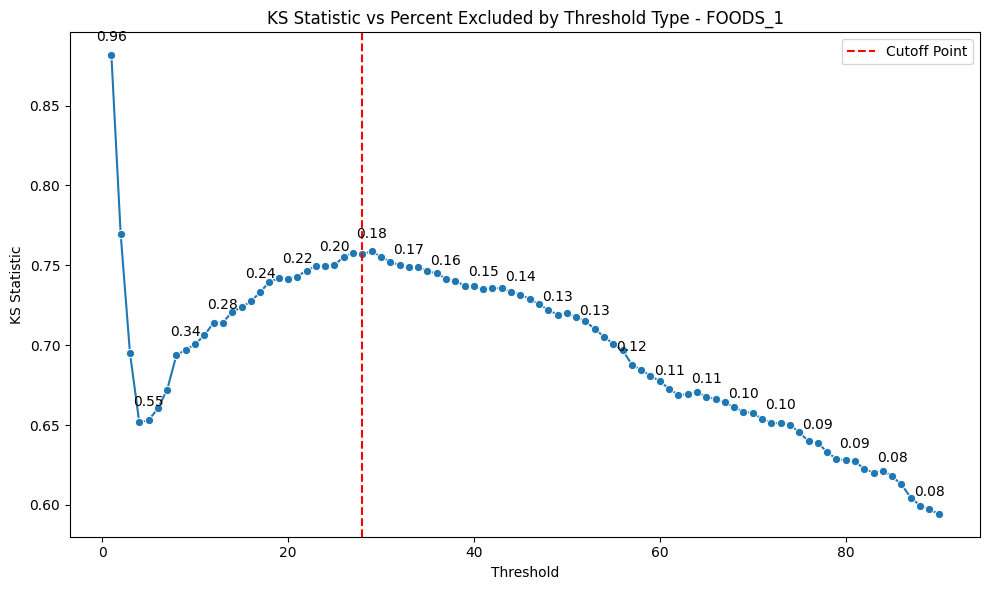

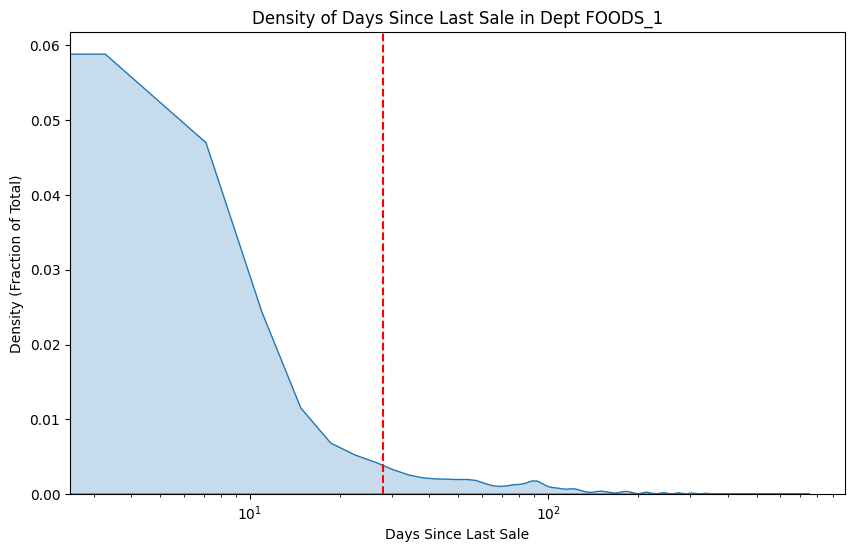

This cutoff would potentially remove 0.18 of observations.


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_10854/2558175782.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_filtered["population"] = "Keep"


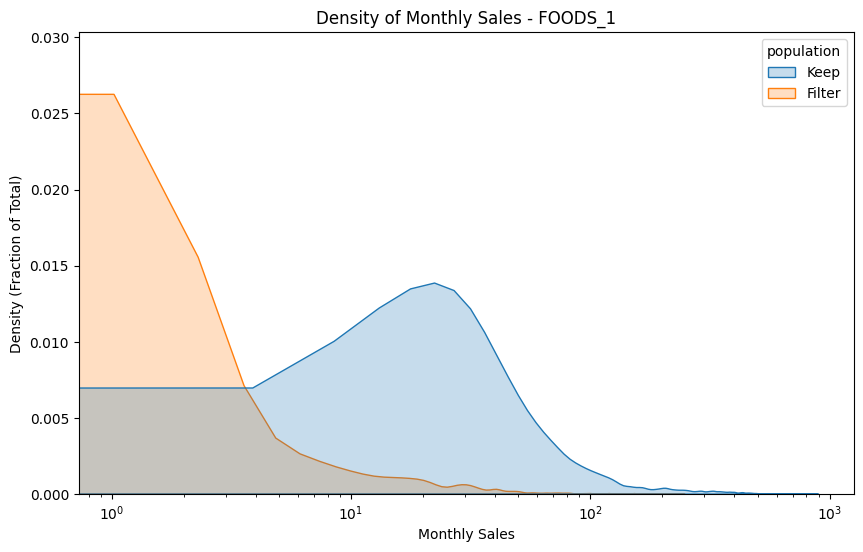

This cutoff would potentially remove 0.18 of observations.


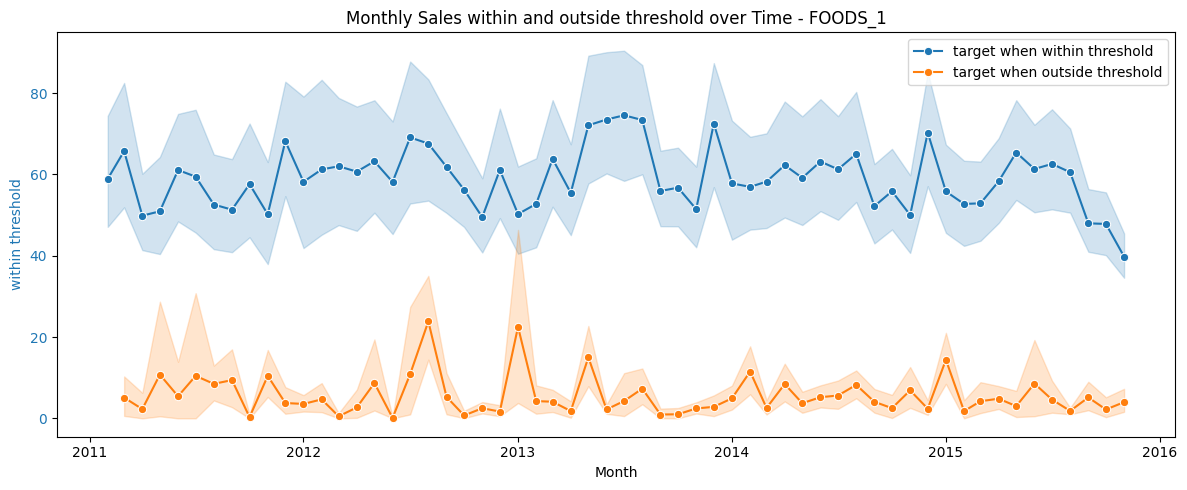

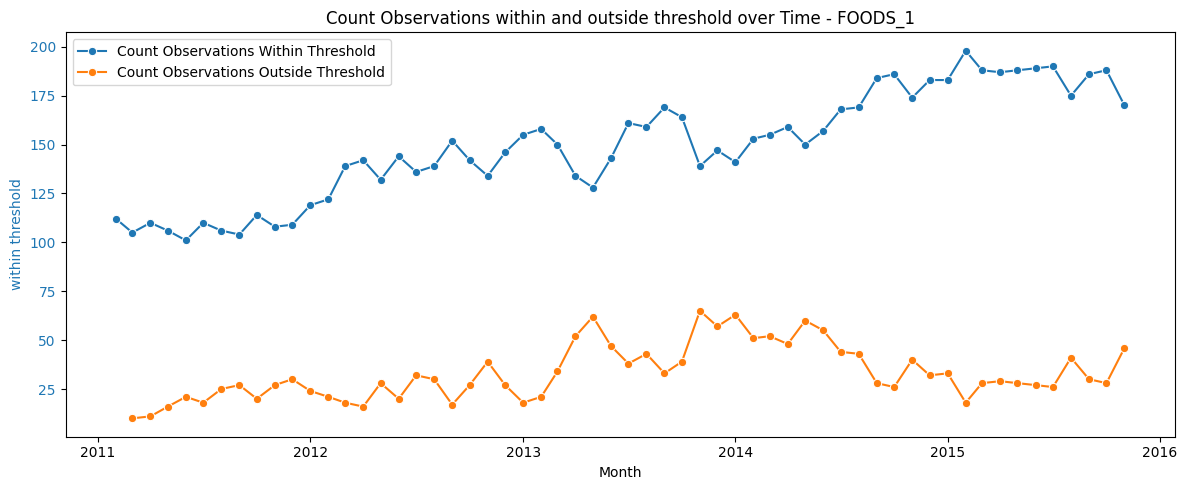

In [5]:
dept_id = "FOODS_1"
cutoff = 28
plot_cutoff_per_dept(df_cutoff_analysis = df_cutoff_analysis, dept_id=dept_id, plot_inflection_point=cutoff)
plot_distribution_days_since_last_sales(dept_id= dept_id, cutoff_point=cutoff)
plot_sales_distribution_comparisson(dept_id, cutoff)
plot_stockout_threhodls_per_dept(dept_id, cutoff)
plot_count_stockout_threhodls_per_dept(dept_id, cutoff)

# Foods 2

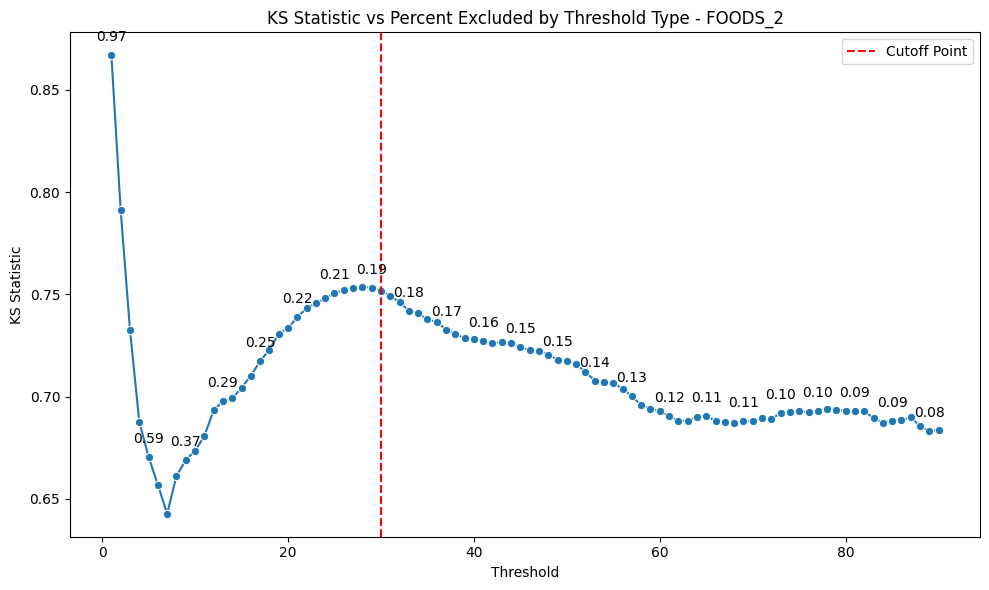

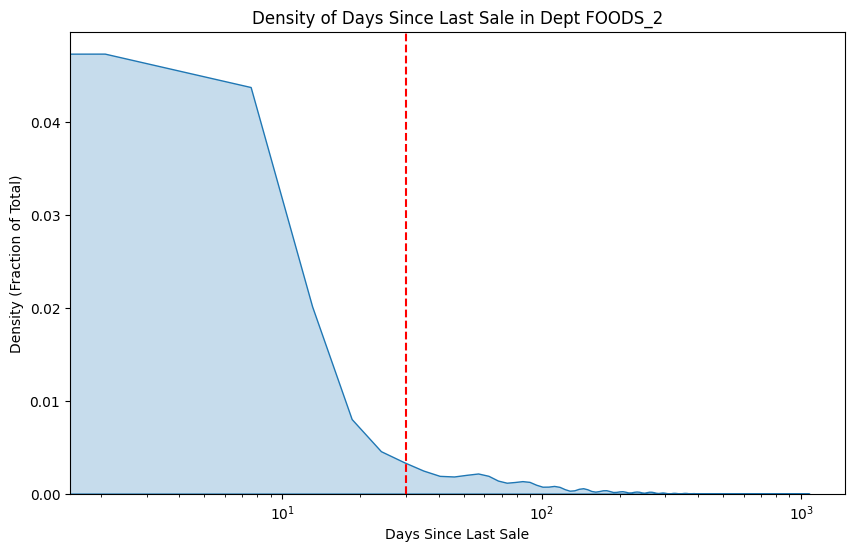

This cutoff would potentially remove 0.18 of observations.


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_10854/2558175782.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_filtered["population"] = "Keep"


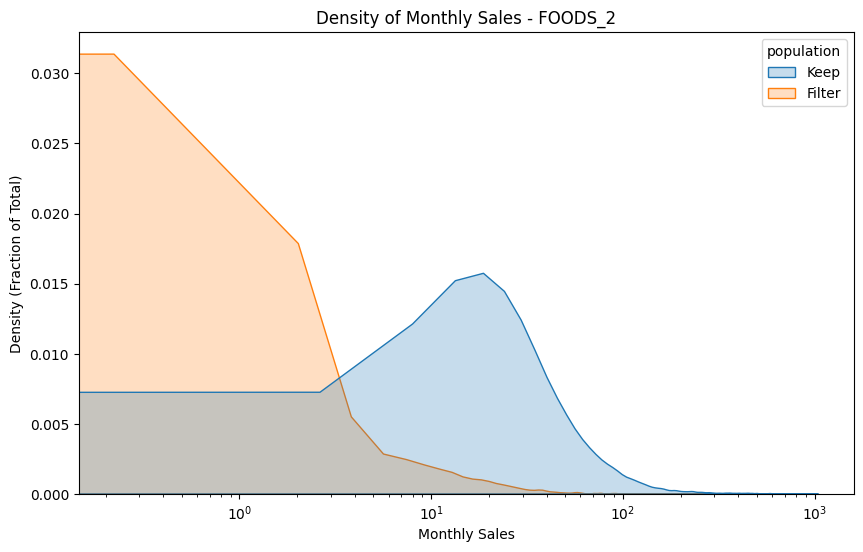

This cutoff would potentially remove 0.18 of observations.


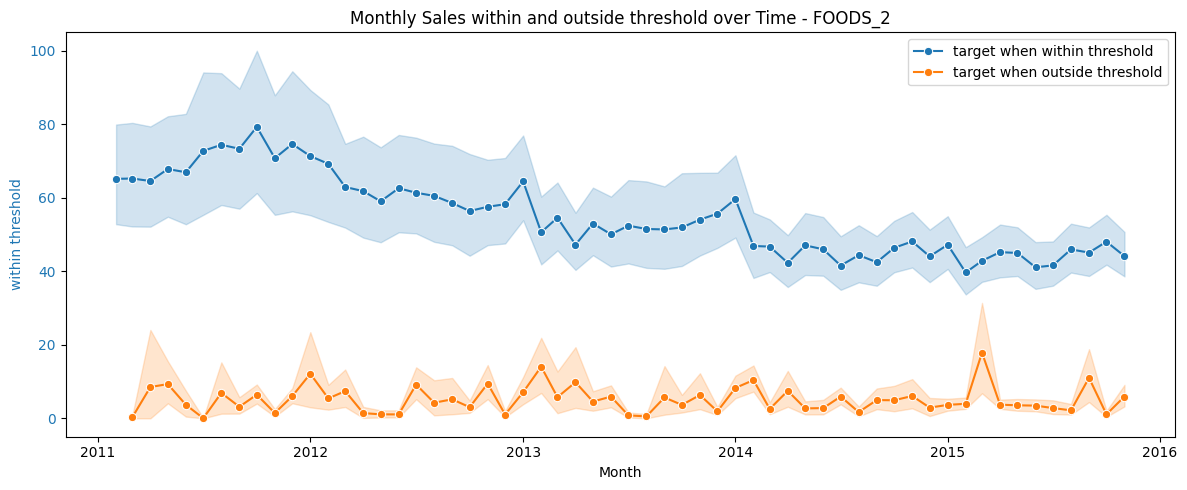

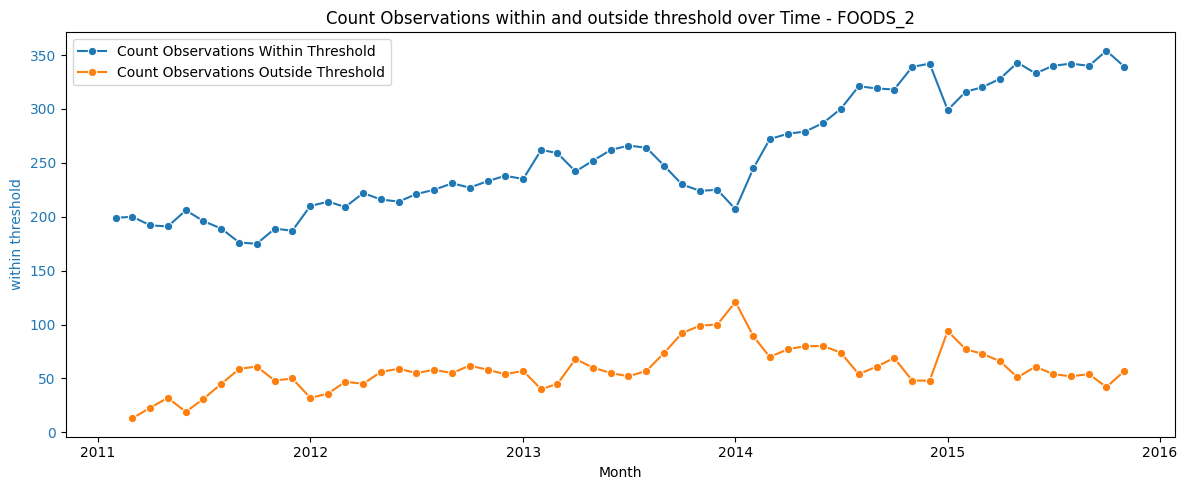

In [6]:
dept_id = "FOODS_2"
cutoff = 30
plot_cutoff_per_dept(df_cutoff_analysis = df_cutoff_analysis, dept_id=dept_id, plot_inflection_point=cutoff)
plot_distribution_days_since_last_sales(dept_id= dept_id, cutoff_point=cutoff)
plot_sales_distribution_comparisson(dept_id, cutoff)
plot_stockout_threhodls_per_dept(dept_id, cutoff)
plot_count_stockout_threhodls_per_dept(dept_id, cutoff)

# FOODS 3

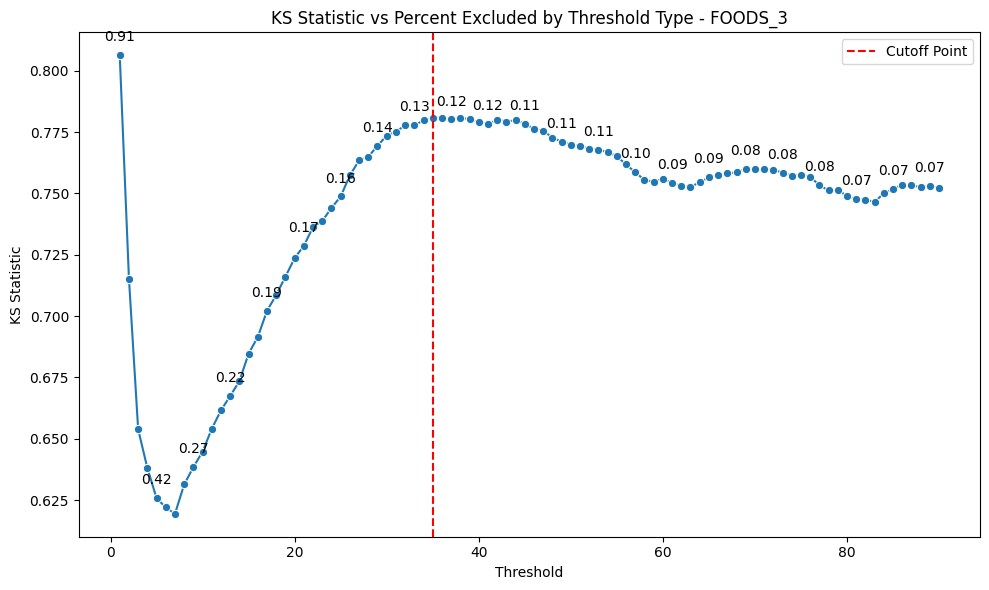

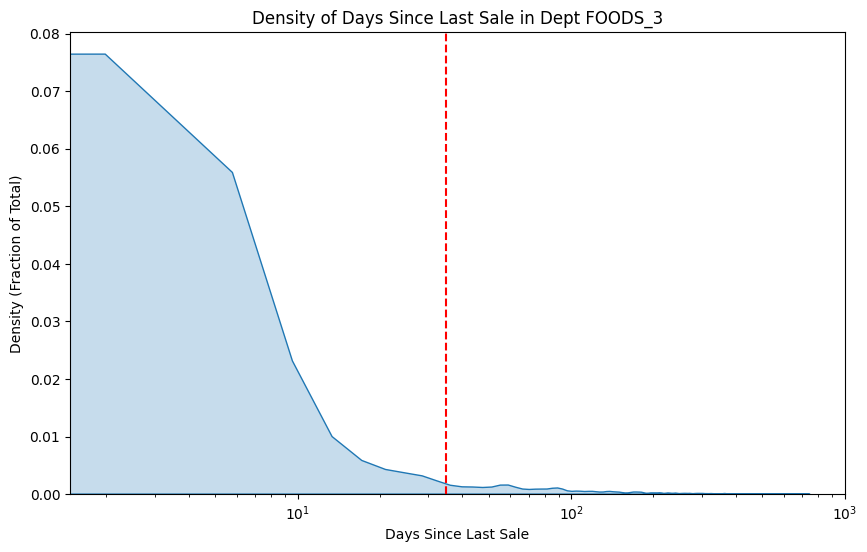

This cutoff would potentially remove 0.13 of observations.


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_10854/2558175782.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_filtered["population"] = "Keep"


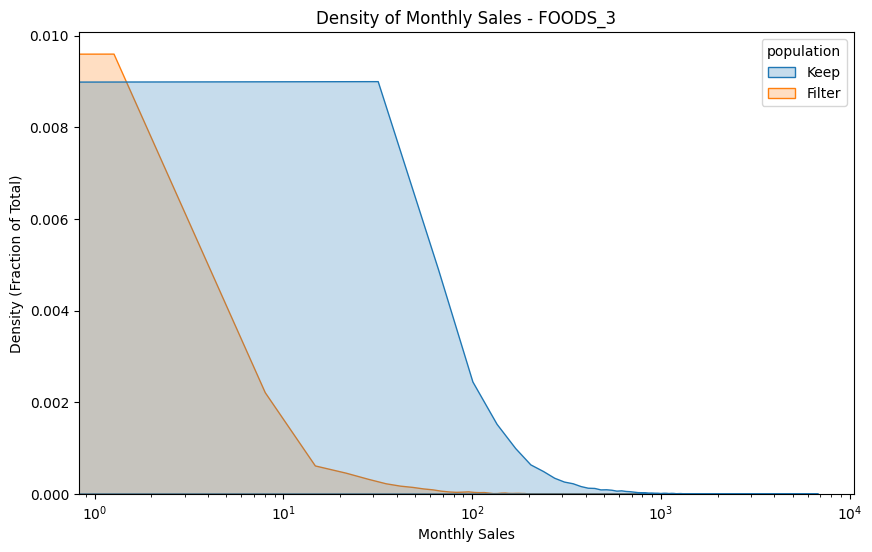

This cutoff would potentially remove 0.13 of observations.


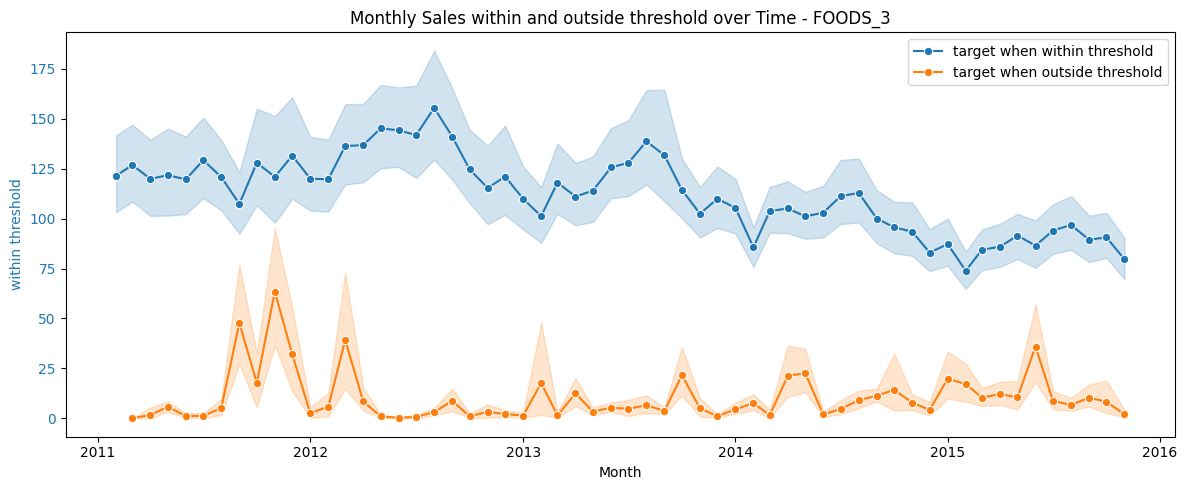

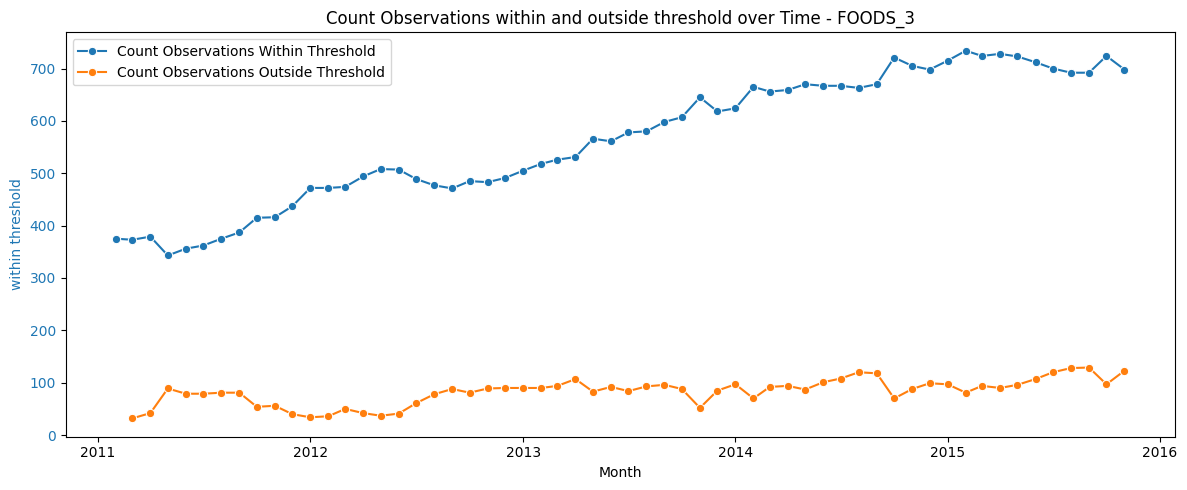

In [7]:
dept_id = "FOODS_3"
cutoff = 35
plot_cutoff_per_dept(df_cutoff_analysis = df_cutoff_analysis, dept_id=dept_id, plot_inflection_point=cutoff)
plot_distribution_days_since_last_sales(dept_id= dept_id, cutoff_point=cutoff)
plot_sales_distribution_comparisson(dept_id, cutoff)
plot_stockout_threhodls_per_dept(dept_id, cutoff)
plot_count_stockout_threhodls_per_dept(dept_id, cutoff)

# HOUSEHOLD 1

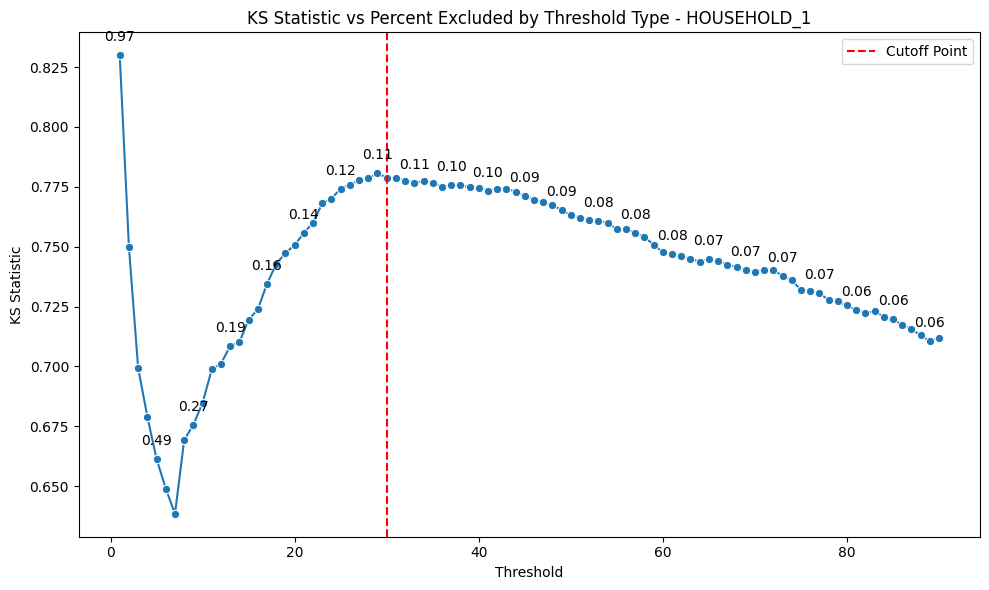

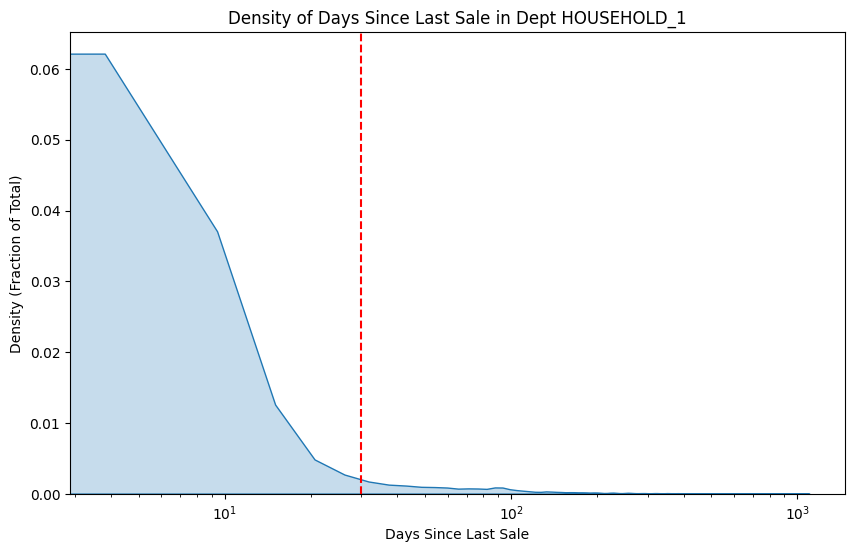

This cutoff would potentially remove 0.11 of observations.


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_10854/2558175782.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_filtered["population"] = "Keep"


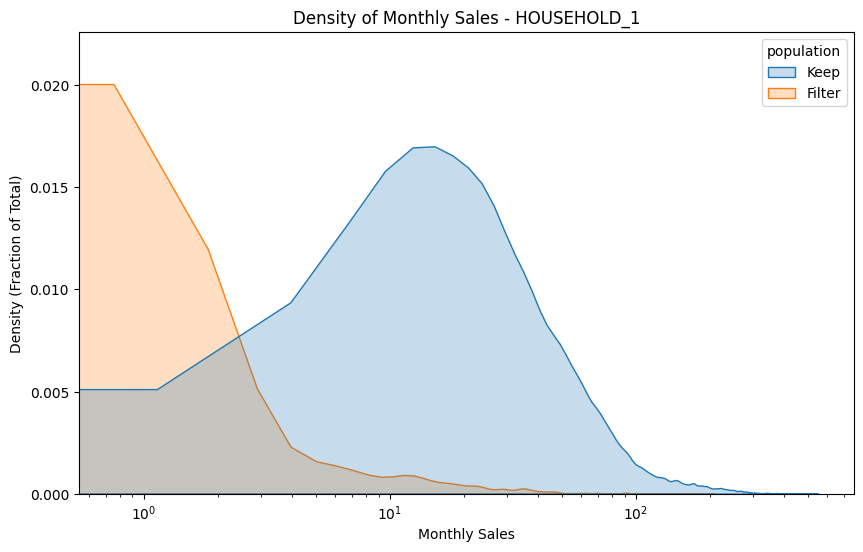

This cutoff would potentially remove 0.11 of observations.


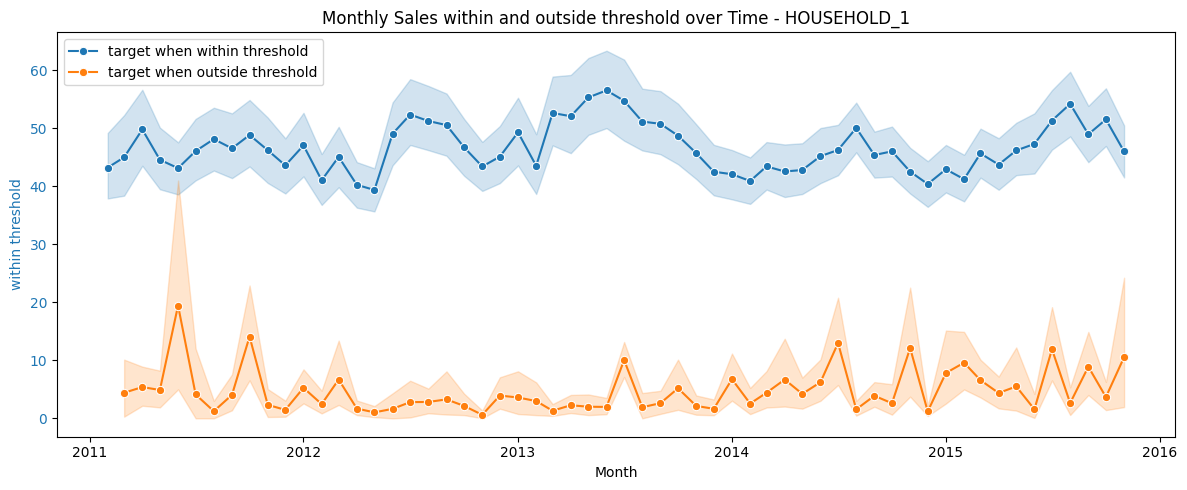

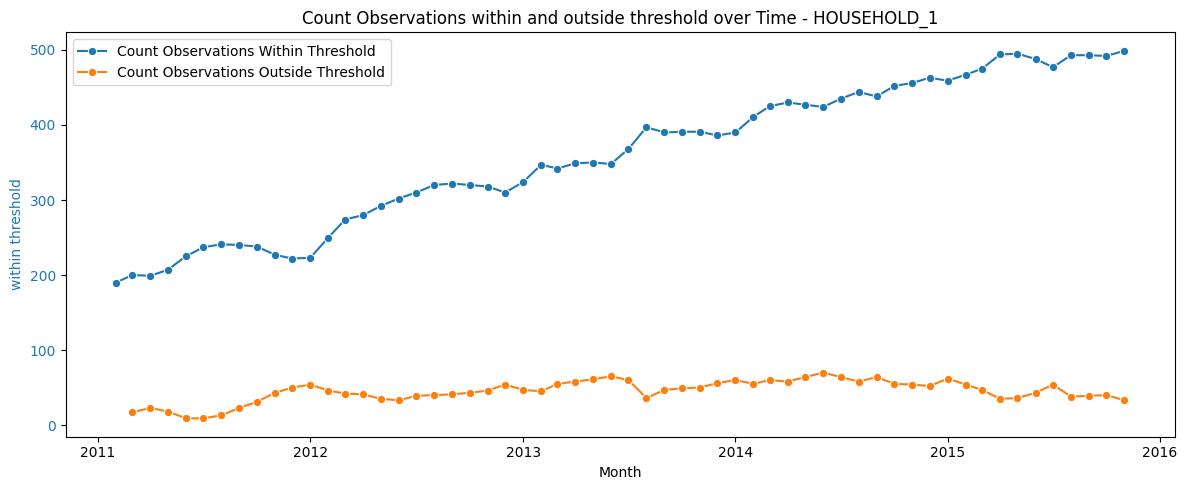

In [8]:
dept_id = "HOUSEHOLD_1"
cutoff = 30
plot_cutoff_per_dept(df_cutoff_analysis = df_cutoff_analysis, dept_id=dept_id, plot_inflection_point=cutoff)
plot_distribution_days_since_last_sales(dept_id= dept_id, cutoff_point=cutoff)
plot_sales_distribution_comparisson(dept_id, cutoff)
plot_stockout_threhodls_per_dept(dept_id, cutoff)
plot_count_stockout_threhodls_per_dept(dept_id, cutoff)

# HOUSEHOLD 2

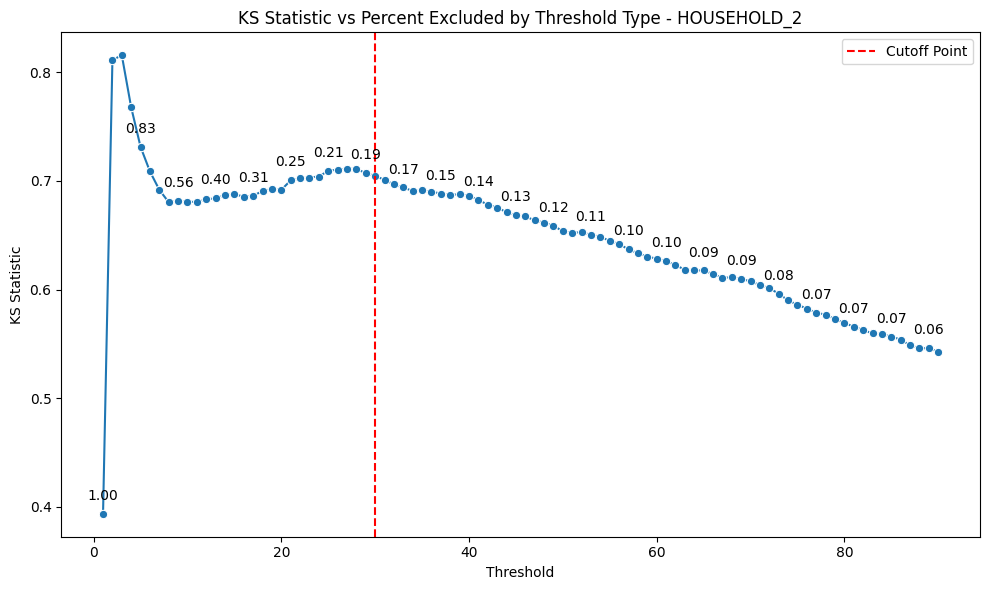

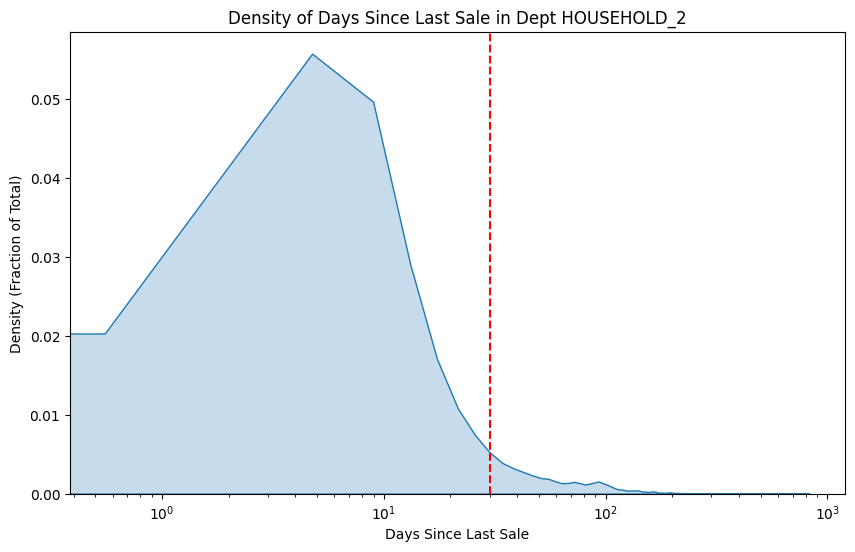

This cutoff would potentially remove 0.18 of observations.


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_10854/2558175782.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_filtered["population"] = "Keep"


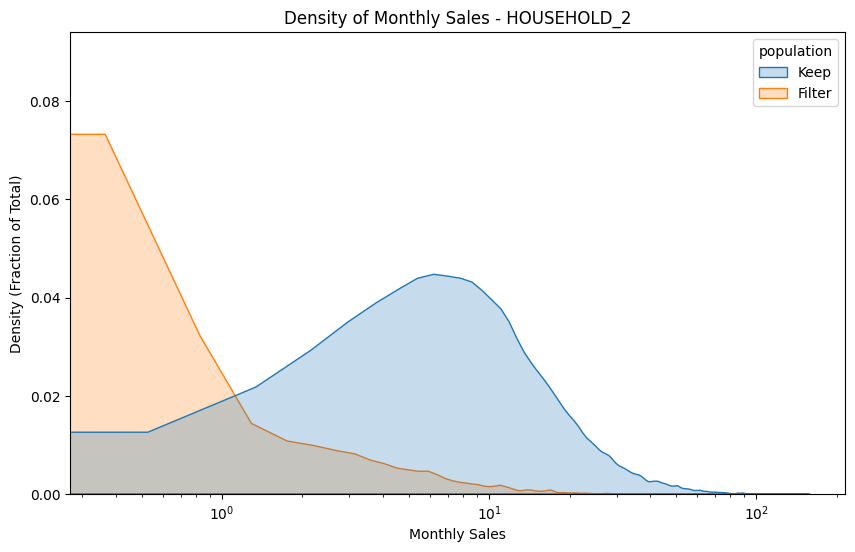

This cutoff would potentially remove 0.18 of observations.


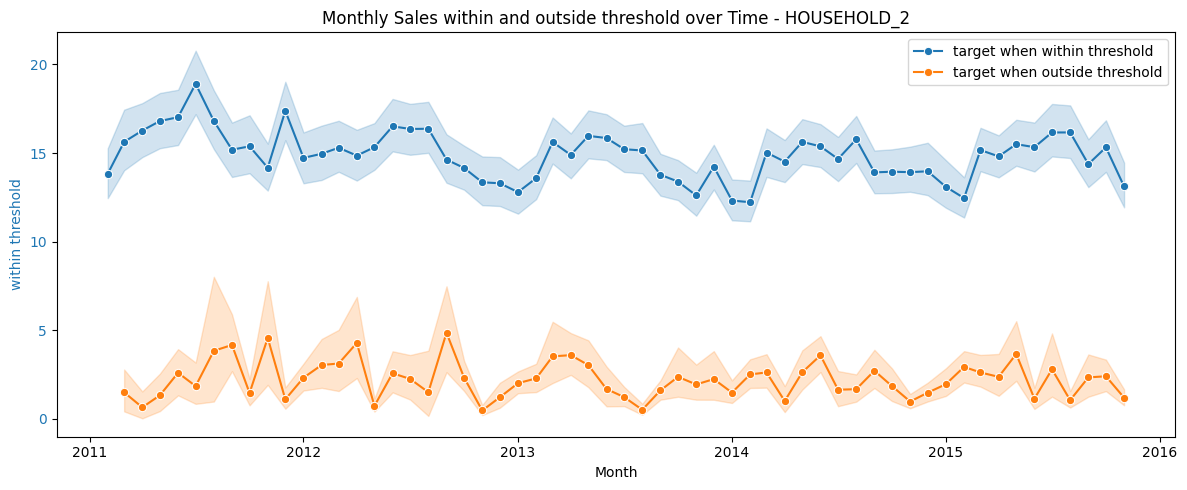

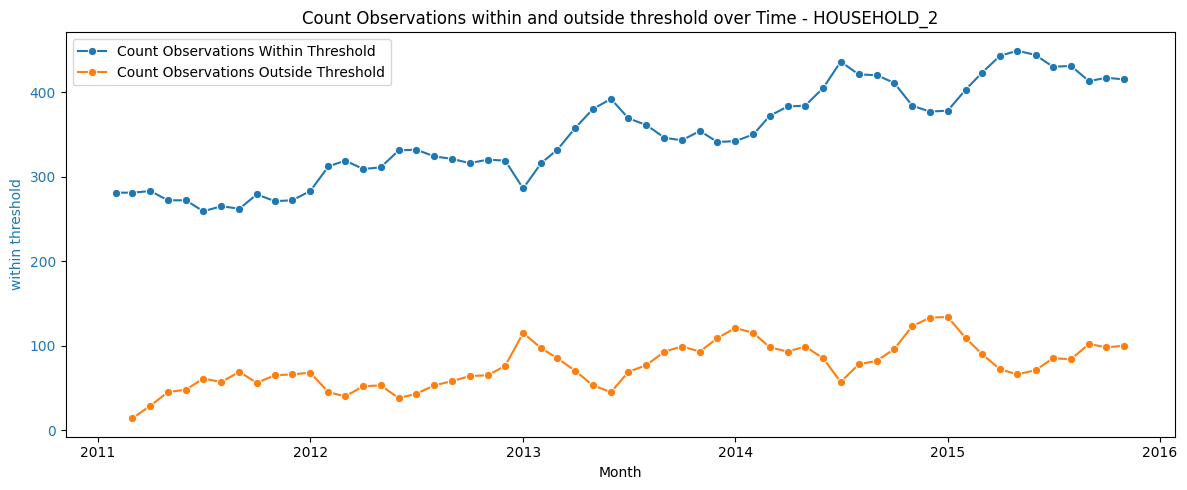

In [9]:
dept_id = "HOUSEHOLD_2"
cutoff = 30
plot_cutoff_per_dept(df_cutoff_analysis = df_cutoff_analysis, dept_id=dept_id, plot_inflection_point=cutoff)
plot_distribution_days_since_last_sales(dept_id= dept_id, cutoff_point=cutoff)
plot_sales_distribution_comparisson(dept_id, cutoff)
plot_stockout_threhodls_per_dept(dept_id, cutoff)
plot_count_stockout_threhodls_per_dept(dept_id, cutoff)

# HOBBIES 1

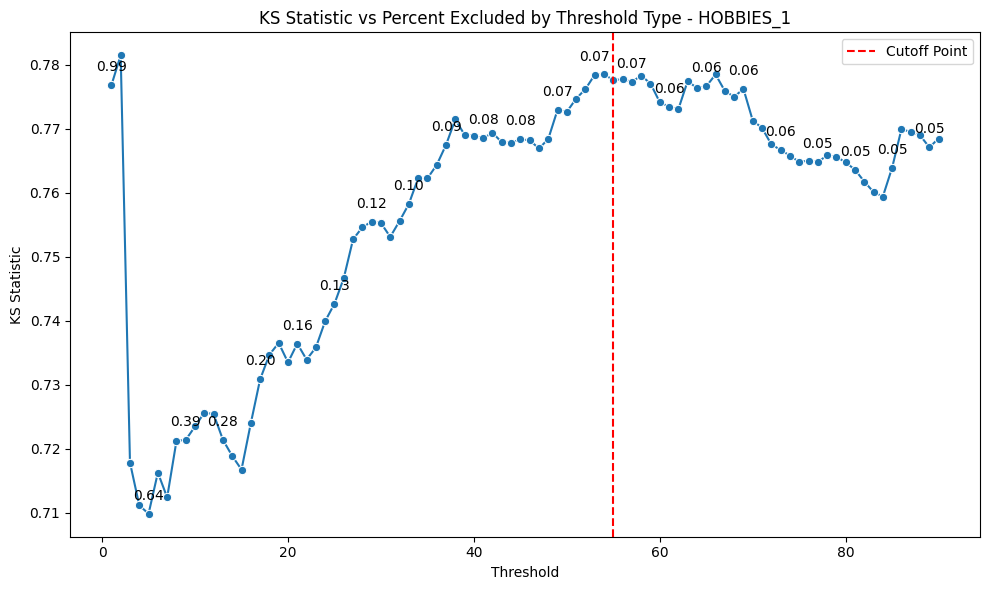

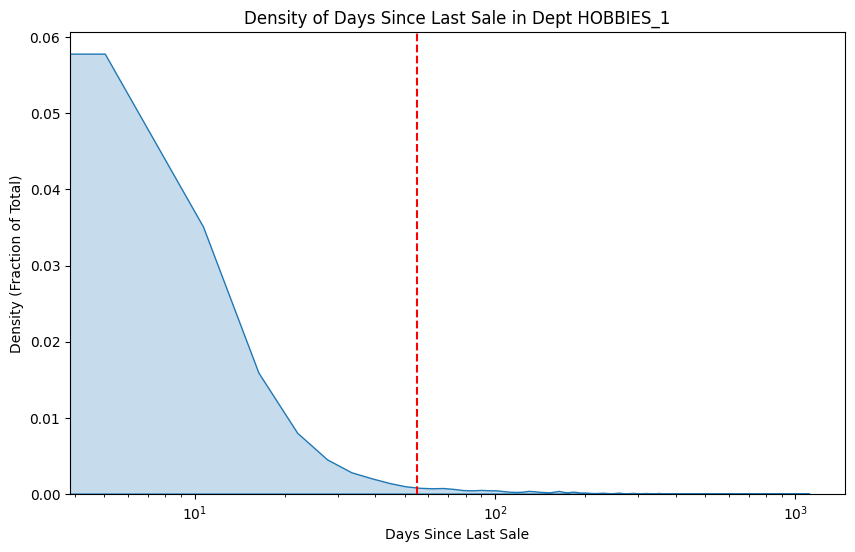

This cutoff would potentially remove 0.07 of observations.


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_10854/2558175782.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_filtered["population"] = "Keep"


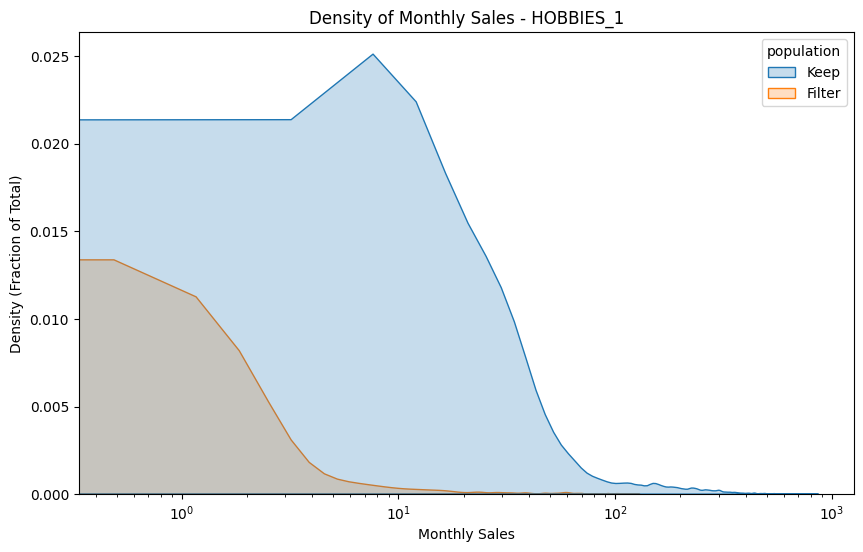

This cutoff would potentially remove 0.07 of observations.


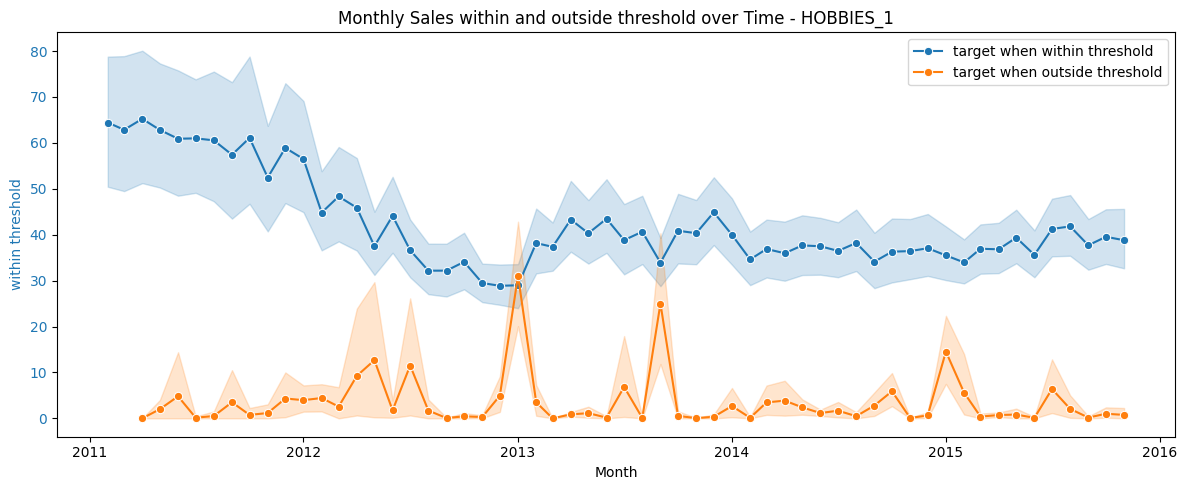

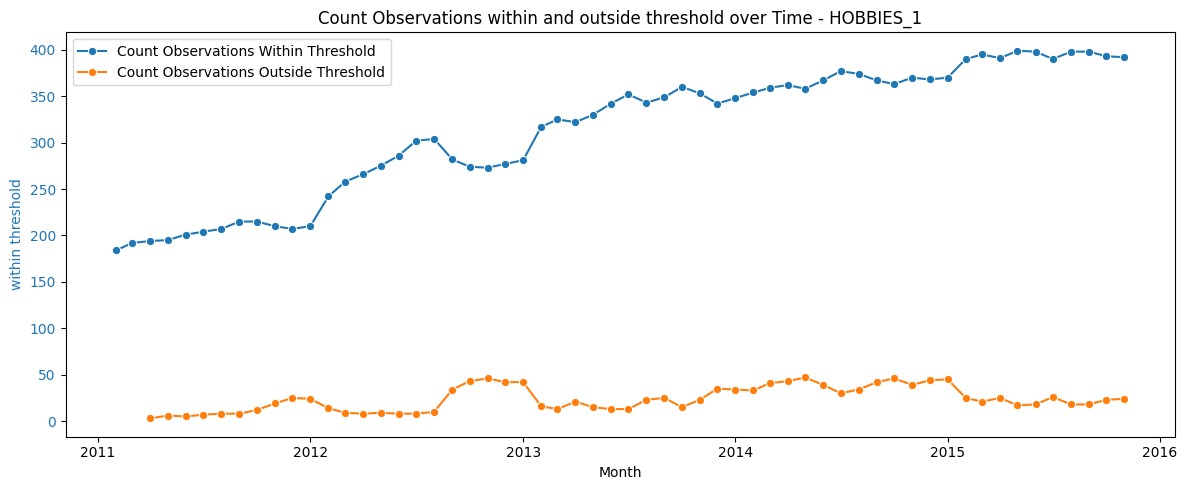

In [10]:
dept_id = "HOBBIES_1"
cutoff = 55
plot_cutoff_per_dept(df_cutoff_analysis = df_cutoff_analysis, dept_id=dept_id, plot_inflection_point=cutoff)
plot_distribution_days_since_last_sales(dept_id= dept_id, cutoff_point=cutoff)
plot_sales_distribution_comparisson(dept_id, cutoff)
plot_stockout_threhodls_per_dept(dept_id, cutoff)
plot_count_stockout_threhodls_per_dept(dept_id, cutoff)

# HOBBIES 2

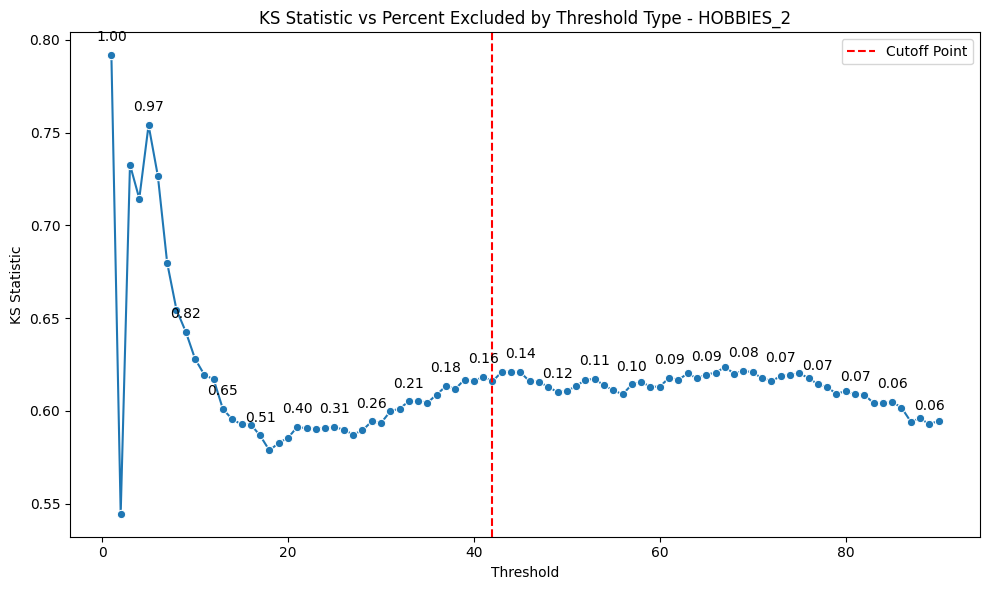

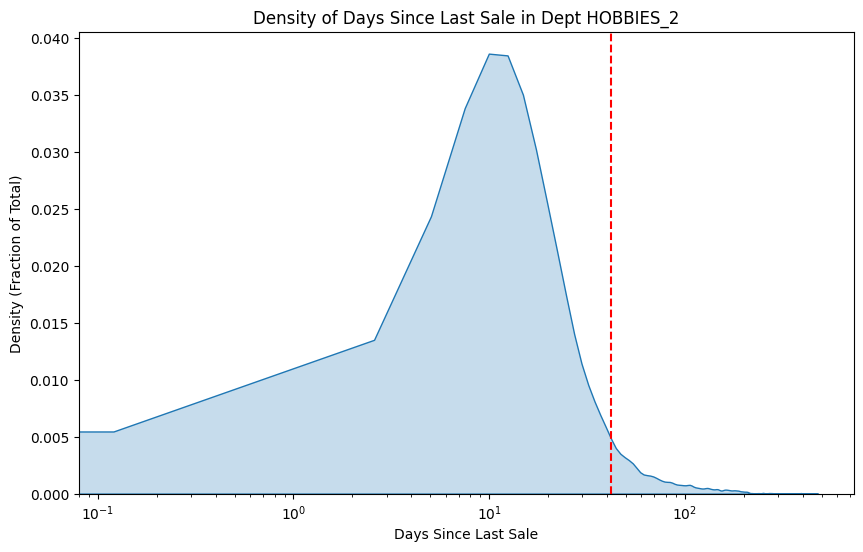

This cutoff would potentially remove 0.14 of observations.


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_10854/2558175782.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_filtered["population"] = "Keep"


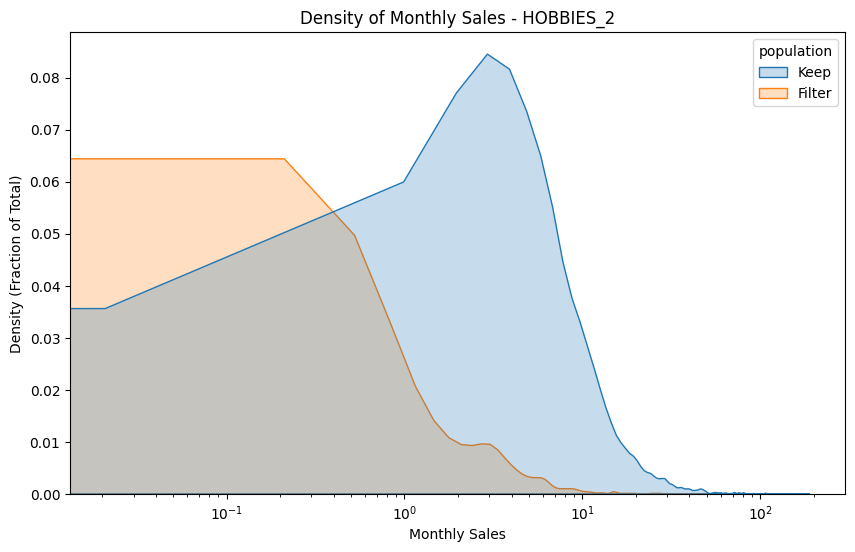

This cutoff would potentially remove 0.14 of observations.


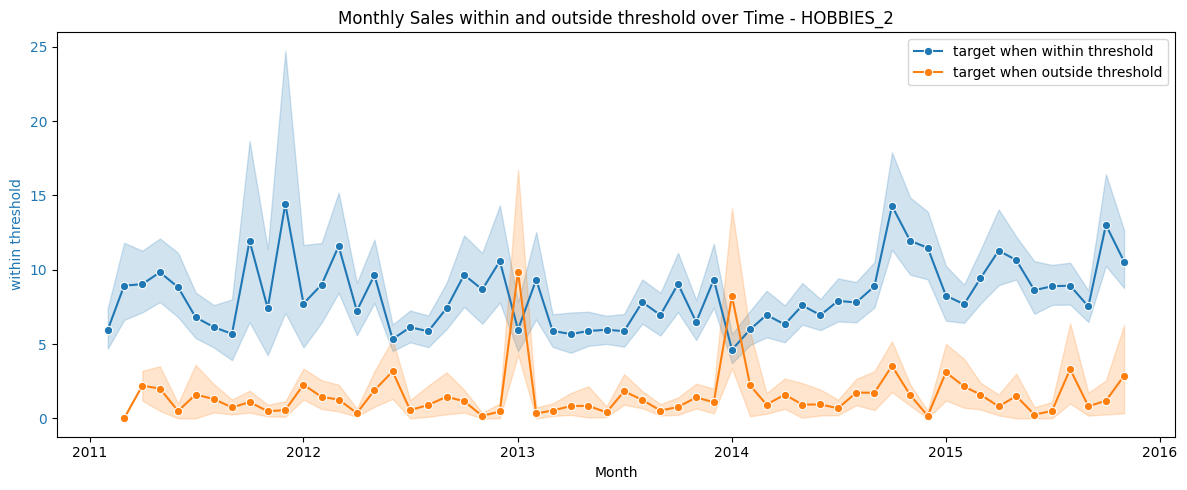

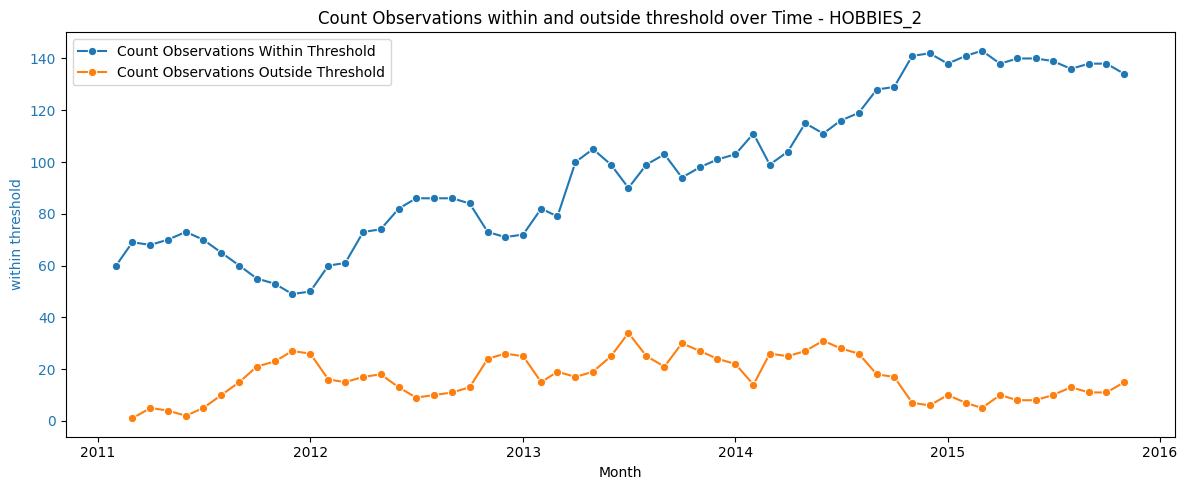

In [11]:
dept_id = "HOBBIES_2"
cutoff = 42
plot_cutoff_per_dept(df_cutoff_analysis = df_cutoff_analysis, dept_id=dept_id, plot_inflection_point=cutoff)
plot_distribution_days_since_last_sales(dept_id= dept_id, cutoff_point=cutoff)
plot_sales_distribution_comparisson(dept_id, cutoff)
plot_stockout_threhodls_per_dept(dept_id, cutoff)
plot_count_stockout_threhodls_per_dept(dept_id, cutoff)